In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color


def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

## CALIBRATION DATA

In [11]:
# load calibration data
led_calibration = pd.read_csv('../../16FlYMaze/calibration_data/4y_led.csv')
led_calibration = pd.concat([
    led_calibration[['Arena','Intensity','Replicate 1']].rename(columns={'Replicate 1':'Peak Intensity (mW/cm^2)','Intensity':'LED Percentage'}),
    led_calibration[['Arena','Intensity','Replicate 2']].rename(columns={'Replicate 2':'Peak Intensity (mW/cm^2)','Intensity':'LED Percentage'}),
    led_calibration[['Arena','Intensity','Replicate 3']].rename(columns={'Replicate 3':'Peak Intensity (mW/cm^2)','Intensity':'LED Percentage'}),
])
led_calibration.head()

,Arena,LED Percentage,Peak Intensity (mW/cm^2)
0,1,100.0,4.921
1,2,100.0,5.023
2,3,100.0,4.982
3,4,100.0,5.018
4,1,50.0,2.475


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Arena 1 r^2 = 0.9993979477567875 p = 4.607809382231322e-32
Arena 2 r^2 = 0.9992767985628871 p = 2.6300062832149424e-31
Arena 3 r^2 = 0.9991445157859887 p = 1.2972797229302421e-30
Arena 4 r^2 = 0.9990069018121545 p = 5.3514625233056115e-30


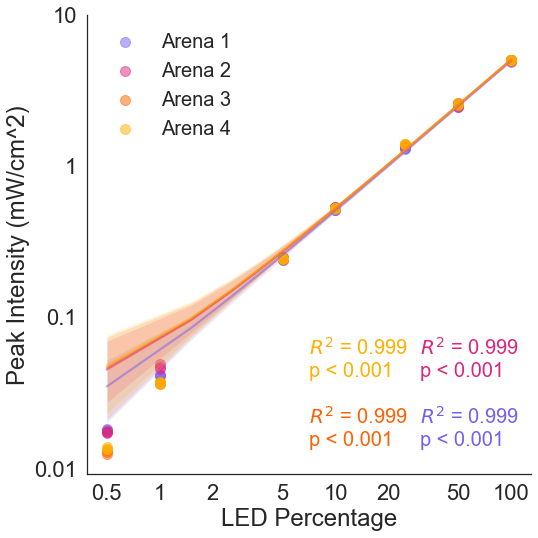

In [12]:
# make a linear model for each arena for Peak Intensity vs LED Percentage and plot the data
sns.set(style='white',font_scale=2)
fig,ax = plt.subplots(1,1,figsize=(8,8))
for arena in led_calibration['Arena'].unique():
    data = led_calibration[led_calibration['Arena']==arena]
    sns.regplot(data=data,x='LED Percentage',y='Peak Intensity (mW/cm^2)',ax=ax,label="Arena " + str(arena),scatter_kws={'s':100,'alpha':0.5,'color':cmap(arena/4)},line_kws={'color':cmap(arena/4), 'alpha':0.5})
    # calculate the r^2 value and p value
    r2 = stats.linregress(data['LED Percentage'],data['Peak Intensity (mW/cm^2)']).rvalue**2
    p = stats.linregress(data['LED Percentage'],data['Peak Intensity (mW/cm^2)']).pvalue
    # add the r^2 value and p value to the plot
    print("Arena " + str(arena) + " r^2 = " + str(r2) + " p = " + str(p))
    if p < 0.001:
        p = 'p < 0.001'
    else:
        p = 'p = ' + str(np.round(p,3))
    ax.text(0.75-((arena-1)//2) *0.25,0.15+(arena-1)%2*0.15,'$R^2$ = ' + str(round(r2,3)) + '\n' + p,transform=ax.transAxes,va='top',ha='left',fontsize=20,color=cmap(arena/4))

ax.set_xlabel('LED Percentage')
ax.set_ylabel('Peak Intensity (mW/cm^2)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.5,1,2,5,10,20,50,100])
ax.set_xticklabels([0.5,1,2,5,10,20,50,100])
ax.set_yticks([0.01,0.1,1,10])
ax.set_yticklabels([0.01,0.1,1,10])
ax.legend(frameon=False,fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig('figures/led_calibration.pdf')
plt.show()

In [4]:
# load full experiment statistics
full_stats = pd.read_csv('../../16FlYMaze/full_stats.csv')
full_stats.head()

,Unnamed: 0,Arena,Length of Experiment,Number of Trials completed,Time of day,Experiment Name,Status,Rewarded Frame Delays,Unrewarded Frame Delays
0,0,0,5173.723670,100,42847,HALMHO_EXP_1_2022-08-30_11-51,Complete,"0.352,0.114,0.117,0.114,0.111,0.118,0.099,0.09...","0.053,0.074,0.078,0.023,0.035,0.016,0.016,0.01..."
1,1,0,2845.515957,100,49686,HALMHO_EXP_2_2022-08-30_13-43,Complete,"0.184,0.118,0.113,0.114,0.129,0.123,0.113,0.12...","0.034,0.018,0.037,0.034,0.413,0.101,0.065,0.16..."
2,2,0,3586.657150,100,55419,HALMHO_EXP_3_2022-08-30_15-22,Complete,"0.442,0.116,0.110,0.120,0.121,0.103,0.101,0.09...","0.095,0.043,0.018,0.019,0.030,0.017,0.017,0.05..."
3,3,0,8224.484932,100,59878,HALMHO_EXP_4_2022-08-30_16-35,Complete,"0.303,0.119,0.121,0.117,0.123,0.124,0.101,0.10...","0.052,0.051,0.034,0.029,0.022,0.048,0.041,0.03..."
4,4,0,3764.996143,100,72065,HALMHO_EXP_5_2022-08-30_19-58,Complete,"0.375,0.115,0.116,0.116,0.119,0.110,0.121,0.14...","0.160,0.018,0.023,0.021,0.019,0.023,0.023,0.01..."


In [5]:
date = full_stats['Experiment Name'].apply(lambda x: x.split('2022-')[1].split('_')[0]).apply(lambda x: datetime.strptime('2022-'+x, '%Y-%m-%d'))
# filter out the data before 10th of August 2022
full_stats = full_stats[date>datetime(2022,8,10)]

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


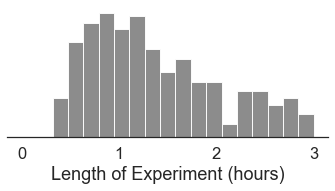

In [6]:
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.hist((full_stats[full_stats["Status"]=="Complete"]['Length of Experiment']/3600),bins=np.linspace(0,np.max(full_stats['Length of Experiment']/3600),20),color='gray',alpha=0.9,density=True)
plt.xlabel("Length of Experiment (hours)")
plt.yticks([])
for i in ax.spines.values():
    i.set_visible(False)
ax.spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/length_of_experiment.pdf',bbox_inches='tight')
plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


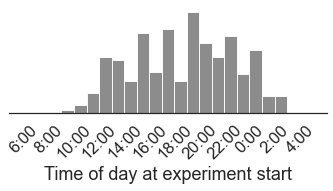

In [7]:
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.hist((full_stats[full_stats["Status"]=="Complete"]['Time of day']-6*3600)%86400,bins=np.arange(0,24*3600,3600),color='gray',alpha=0.9,density=True)

plt.xticks(np.arange(0,24*3600,3600*2),np.roll(['{}:00'.format(i) for i in list(range(0,24,2))],-3),rotation=45)
plt.xlabel("Time of day at experiment start") 
plt.yticks([])
for i in ax.spines.values():
    i.set_visible(False)
ax.spines['bottom'].set_visible(True)
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('figures/time_of_day.pdf',bbox_inches='tight')
plt.show()

In [8]:
rewarded_frame_delays = np.concatenate([np.array([float(v) for v in i.split(',') if v != '']) for i in full_stats['Rewarded Frame Delays'].values])
unrewarded_frame_delays = np.concatenate([np.array([float(v) for v in i.split(',') if v != '']) for i in full_stats['Unrewarded Frame Delays'].values])

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


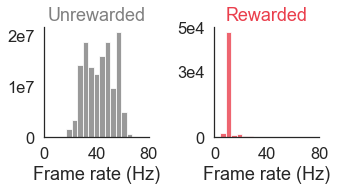

In [9]:
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 2, figsize=(5, 3),sharex=True)
ax[0].hist(1/unrewarded_frame_delays,bins=np.linspace(0,80,20),color='gray',alpha=0.8)
ax[1].hist(1/rewarded_frame_delays,bins=np.linspace(0,80,20),color=cmap(0.6),alpha=0.8)
ax[0].set_xlabel("Frame rate (Hz)")
ax[1].set_xlabel("Frame rate (Hz)")
ax[0].set_yticks([0,1e7,2e7])
ax[0].set_yticklabels([r"0",r"1e7",r"2e7"])
ax[1].set_yticks([0,3e4,5e4])
ax[1].set_yticklabels([r"0",r"3e4",r"5e4"])
for i in ax[0].spines.values():
    i.set_visible(False)
for i in ax[1].spines.values():
    i.set_visible(False)
ax[0].spines['bottom'].set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[1].spines['bottom'].set_visible(True)
ax[1].spines['left'].set_visible(True)
ax[0].set_title("Unrewarded",color='gray')
ax[1].set_title("Rewarded",color=cmap(0.6))
ax[0].set_xlim([0,80])
ax[1].set_xticks([0,40,80])
plt.tight_layout()
plt.savefig('figures/frame_rate.pdf',bbox_inches='tight')
plt.show()